# PROJET DE NLP
# Classification de sentiments, analyse de sentiments de tweets

###  Guillaume Astruc et Guillaume Peltier

### ENSAE IPP 3A

Ce notebook est commenté, vous y trouverez les analyses détaillées de nos preprocessing et modèles. Une synthèse de notre projet est en pièce jointe, deux pages au format pdf.

Dans ce notebook vous pouvez trouver les parties suivantes:

1. Analyse descriptive et preprocessing des données

    1.1. Analyse de la variable cible : sentiment
    1.2. Analyse de la variable textuelle : contenu
        1.2.1. Analyse générale : longueur et analyse des regex
        1.2.2. Preprocessing : nettoyage du texte
        1.2.3. Tokenization
        1.2.4. Analyse sur le texte nettoye : POS, wordcloud, Zipf
        
    1.3. ProfileReport
    1.4. Sous ensemble des sentiments
    
2. Modélisation
    2.1. Classification sur les 8 sentiments principaux
        2.1.1. Modèle de machine learning - baseline
        2.1.2. Modèle de deep learning 
        2.1.3. Data augmentation
        
    2.2. Modèle pré-entrainé : DistilBert
        2.2.1. Sentiment analysis : classification binaire positif ou negatif sentiment
        2.2.2. Fine-tuning de DistilBert pour la classification sur les 8 sentiments
        

# Imports

In [1]:
import string
from ast import literal_eval
from collections import Counter, defaultdict
from string import punctuation

import contractions
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import preprocessor as p
import regex as re
import seaborn as sns
import spacy
import tensorflow as tf
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.word2vec import Word2Vec
from IPython.display import display_html
from keras.layers import (
    GRU,
    LSTM,
    Bidirectional,
    Conv1D,
    Conv2D,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    GlobalAveragePooling1D,
    GlobalMaxPooling1D,
    Input,
    MaxPooling1D,
    SpatialDropout1D,
    concatenate,
)
from keras.models import Model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from langdetect import detect
from nltk.corpus import stopwords, words
from nltk.metrics.distance import jaccard_distance
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.tokenize import RegexpTokenizer, TweetTokenizer, word_tokenize
from nltk.util import ngrams
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, label_binarize
from spacy import displacy
from tqdm import tqdm
from transformers import (
    AutoTokenizer,
    TFAutoModelForSequenceClassification,
    create_optimizer,
    pipeline,
)
from wordcloud import WordCloud

2022-04-24 07:49:58.673314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-24 07:49:58.673349: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Dataset Table

In [66]:
df = pd.read_csv(r'tweet_emotions.csv')
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


----------------------------------------------------------------------------------------------

# 1 - Analyse descriptive et preprocessing des données

In [67]:
print("Initialement, la table contient :", len(df), "tweets.")
print("Les tweets sont classés en :", len(df["sentiment"].unique()), "sentiments.")

Initialement, la table contient : 40000 tweets.
Les tweets sont classés en : 13 sentiments.


Certains tweets ont des tweet_id differents, des sentiments differents, mais des contents identiques : on drop les duplicats sur le subset sentiment, content.

In [68]:
#df[df['content'].duplicated()==True]
df[df['content'] == "I'm at work"]

,tweet_id,sentiment,content
147,1957001506,relief,I'm at work
1026,1957198430,neutral,I'm at work


In [69]:
df = df.drop_duplicates(subset=['sentiment','content'])
print("La table contient maintenant:",len(df),"tweets.")

La table contient maintenant: 39909 tweets.


In [70]:
print("Il reste", len(df[df['content'].duplicated()==True]), 
      "tweets qui ont le même content mais des sentiments associés différents.")

Il reste 82 tweets qui ont le même content mais des sentiments associés différents.


Dans un premier temps, on peut enlever ces 82 tweets, et on verra plus tard, si on reclassifie ces tweets, ou bien si on peut tirer de l'information sur les proximites des classes.

In [71]:
df = df.drop_duplicates(subset=['content'])
print("La table contient maintenant:",len(df),"tweets.")

La table contient maintenant: 39827 tweets.


## 1.1- Analyse de la variable cible : sentiment

In [72]:
# Nous vérifions le nombre d'articles par catégorie
df.groupby(df.sentiment).size()

sentiment
anger          110
boredom        179
empty          822
enthusiasm     758
fun           1775
happiness     5184
hate          1322
love          3785
neutral       8598
relief        1522
sadness       5154
surprise      2181
worry         8437
dtype: int64

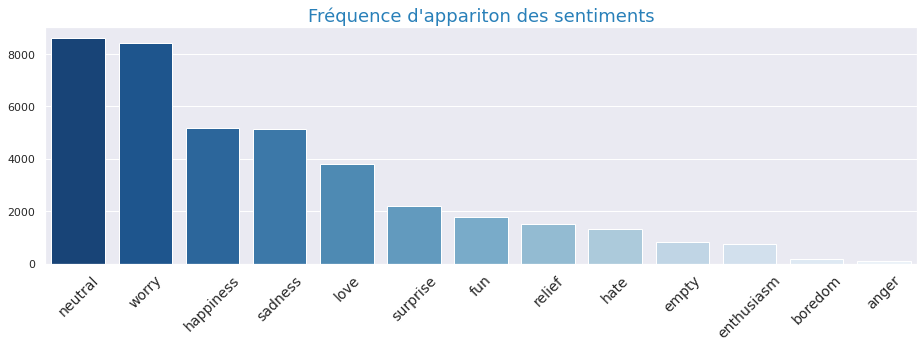

In [73]:
occ_sent = Counter(df["sentiment"])
occ_sent_sorted = dict(sorted(occ_sent.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(13, 5))
sns.barplot(
    x=list(occ_sent_sorted.keys()), y=list(occ_sent_sorted.values()), palette="Blues_r"
)
plt.tick_params(axis="x", labelsize=14)
plt.title("Fréquence d'appariton des sentiments", fontsize=18, color="#2980b9")
plt.xticks(rotation=45)
plt.tight_layout()

On voit que les classes sont asssez déséquilibrés. Dans l'idéal, dans le cadre d'une tache de classification sur ces 13 sentiments, il faudrait faire de la data augmentation ou reéquilibrer les classes. 

On pourrait se demander si les "type de sentiments", c'est à dire, positif, négatif ou neutral sont aussi déséquilibrés.

In [86]:
positive_sentiments = ["love", "fun", "happiness"]
negative_sentiments = ["worry", "sadness"]
neutral_sentiments = ["neutral", "suprise", "relief"]

def sent_type(sent):
    if sent in positive_sentiments:
        return "positive"
    elif sent in negative_sentiments:
        return "negative"
    else :
        return "neutral"
    
df["sentiment_type"] = df.sentiment.apply(sent_type)

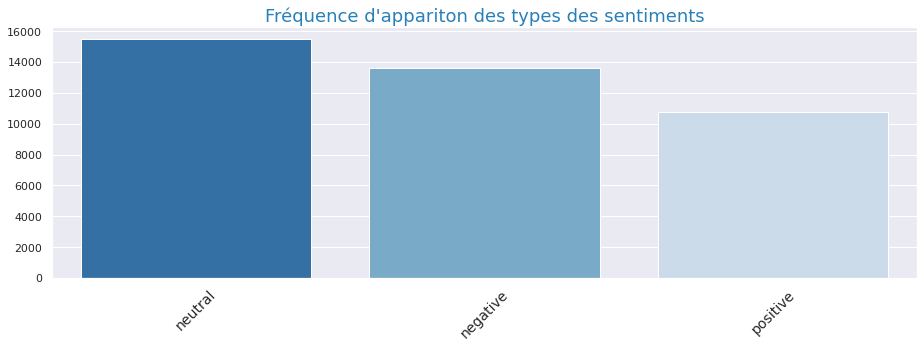

In [87]:
occ_sent = Counter(df["sentiment_type"])
occ_sent_sorted = dict(sorted(occ_sent.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(13, 5))
sns.barplot(
    x=list(occ_sent_sorted.keys()), y=list(occ_sent_sorted.values()), palette="Blues_r"
)
plt.tick_params(axis="x", labelsize=14)
plt.title("Fréquence d'appariton des types des sentiments", fontsize=18, color="#2980b9")
plt.xticks(rotation=45)
plt.tight_layout()


Les types de sentiments sont beaucoup moins déséquilibrés, on peut s'attendre à de meilleure performance sur l'analyse de sentiment que sur de la classification des 13 sentiments de part la différence de classe et l'équilibre des classes

## 1.2- Analyse de la variable textuelle : contenu

### 1.2.1- Analyse generale : longueur et analyse des regex

Longueur moyenne des contenus :

In [74]:
print("La longueur moyenne des tweets est", int(df.content.apply(len).mean()))

La longueur moyenne des tweets est 73


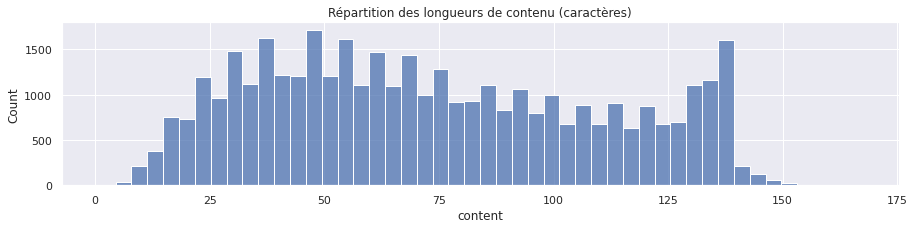

In [75]:
plt.figure(figsize = (15,3))
sns.histplot(df.content.apply(len)) #.hist(bins=40)
plt.title("Répartition des longueurs de contenu (caractères)")
plt.show()

In [76]:
df.content.apply(len).describe()

count    39827.000000
mean        73.530821
std         36.490448
min          1.000000
25%         43.000000
50%         69.000000
75%        103.000000
max        167.000000
Name: content, dtype: float64

Analyse des regex :

In [77]:
# Regular expression that matches any sequence of numbers:
at_prog = re.compile("@")
hash_prog = re.compile("#")
int_prog = re.compile("[0-9]+")
float_prog = re.compile("[0-9]+\.?[0-9]*")
percent_prog = re.compile("[0-9]+\.?[0-9]*%")
year_prog = re.compile(
    "[12][089][0-9][0-9]"
)  # a year between 1800 and 2099. # 1[89][0-9][0-9]|20[0-9][0-9]
df1 = df.drop_duplicates(
    "content"
)  # Don't forget to compute over unique elements if it applies
# Calculating number of matches for every abstract
progs = [at_prog, hash_prog, int_prog, float_prog, percent_prog, year_prog]
nb_types = ["@", "#", "ints", "floats", "percents", "years"]

for prog, nb_type in zip(progs, nb_types):
    df1[nb_type] = df1["content"].apply(lambda x: len(prog.split(x)) - 1).array
df1[nb_types].head()

,@,#,ints,floats,percents,years
0,1,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,1,0,0,0,0,0


In [78]:
nb_percent_types = ["".join([t, "%"]) for t in nb_types]
# Don't forget to compute over unique abstracts
df1 = df.drop_duplicates("content")

for prog, nb_type in zip(progs, nb_percent_types):
    df1[nb_type] = (
        df1["content"]
        .apply(lambda x: 100 * (1 - len("".join(prog.split(x))) / len(x)))
        .array
    )
df1[nb_percent_types + ["content"]].head()

,@%,#%,ints%,floats%,percents%,years%,content
0,1.086957,0.0,0.0,0.0,0.0,0.0,@tiffanylue i know i was listenin to bad habi...
1,0.000000,0.0,0.0,0.0,0.0,0.0,Layin n bed with a headache ughhhh...waitin o...
2,0.000000,0.0,0.0,0.0,0.0,0.0,Funeral ceremony...gloomy friday...
3,0.000000,0.0,0.0,0.0,0.0,0.0,wants to hang out with friends SOON!
4,1.162791,0.0,0.0,0.0,0.0,0.0,@dannycastillo We want to trade with someone w...


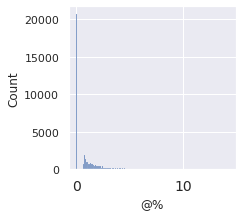

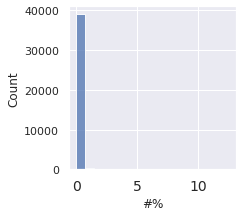

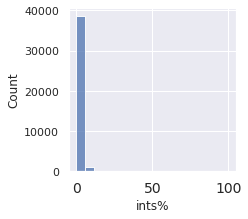

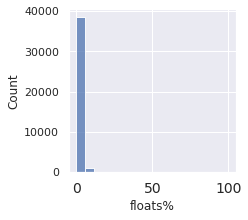

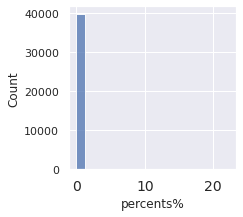

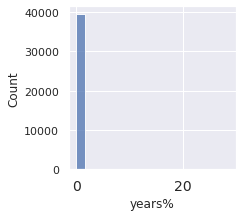

In [79]:
for nbp in nb_percent_types:
    plt.figure(figsize=(3, 3))
    sns.histplot(df1[nbp])
    plt.tick_params(axis="x", labelsize=14)
    plt.show()

In [80]:
%%capture
# repartition des regex par categorie

categories = list(df.sentiment.drop_duplicates().values)
axs = []
for category in categories:
    is_category = df["sentiment"] == category
    df1 = df[is_category]
    nb_percent_types = ["".join([t, "%"]) for t in nb_types]
    for prog, nb_type in zip(progs, nb_percent_types):
        df1[nb_type] = (
            df1["content"]
            .apply(lambda x: 100 * (1 - len("".join(prog.split(x))) / len(x)))
            .array
        )
        # df1[nb_percent_types+['content']].head()
        # df1[nb_percent_types].hist()
    axs.append((df1[nb_percent_types].copy(), category))

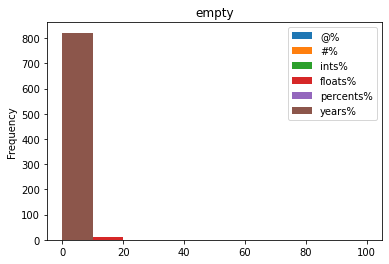

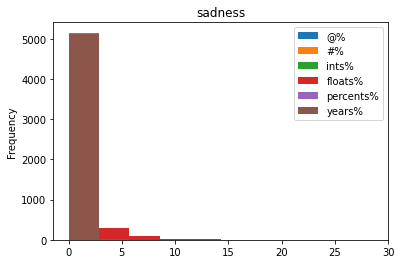

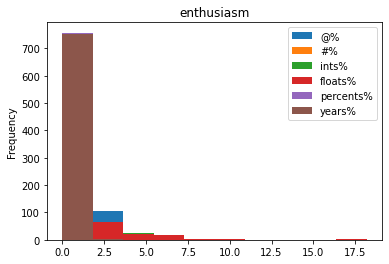

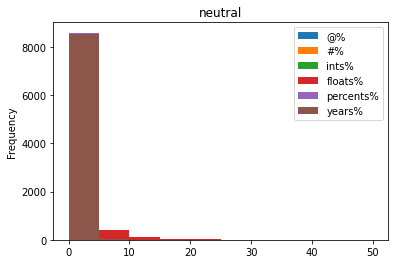

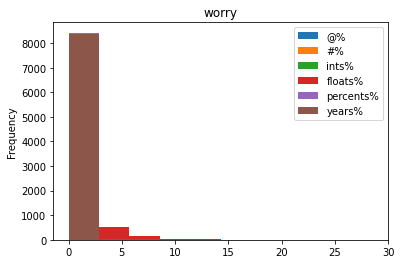

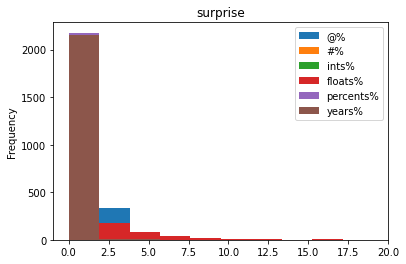

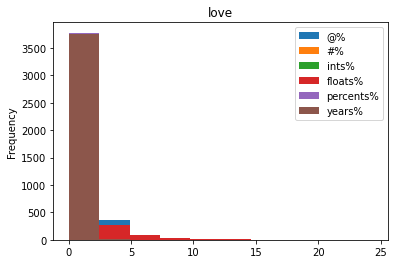

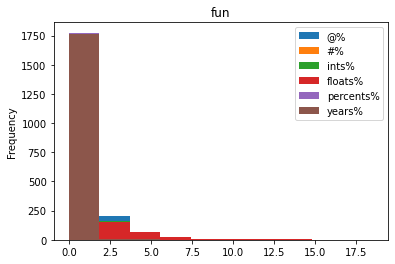

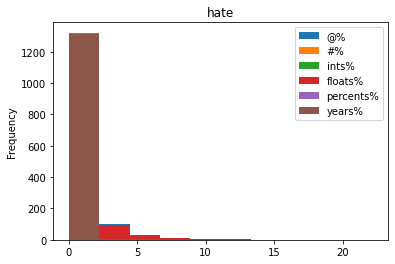

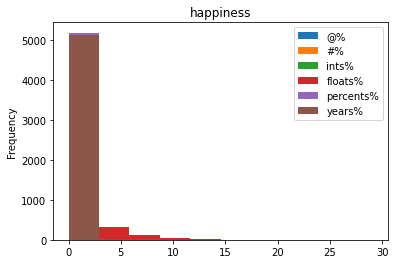

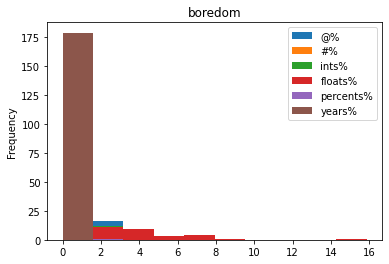

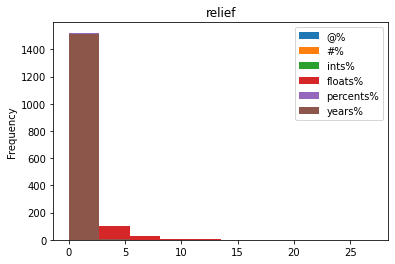

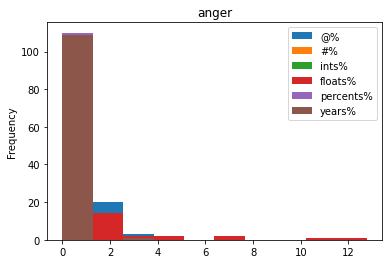

In [18]:
for ax, category in axs:
    ax.plot(
        kind="hist", subplots=False, sharex=True, sharey=True, title="%s" % (category)
    )
plt.show()


Presque la moitié des tweets contiennent des tags, et seulement 2% des tweets contiennents de #. On constate qu'on a pas un sentiments qui tag plus ou hastag plus qu'un autre.

### 1.2.2- Preprocessing : nettoyage du texte

Pour nettoyer les tweets, on enleve :

    - URLs
    - Hashtags (not the content)
    - Mentions
    - Reserved words (RT, FAV)
    - Emojis, Smileys
    - JSON and .txt file support
    - punctuation
    - Number
    - Stop words
    
On corrige les fautes d'orthographes avec Speller, on corrige les contractions, on lemmatise, on normalise les espaces entre les mots, on réécrit tout en minuscule et on enleve tous les tweets pas en anglais.

Remarque : Dans nos premieres versions de preprocessing, pour ces mêmes taches, les fonctions et ordre d'execution de ces fonctions ont fait que trop de mots étaient enlevés: plus de la moitié des mots étaient supprimés et les phrases obtenues n'avait plus de sens (problematique pour les methodes d'embedding avec contextualisation). 

In [81]:
nltk.download("omw-1.4")
nltk.download("wordnet")

[nltk_data] Downloading package omw-1.4 to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [82]:
nltk.download("stopwords")
# en_stop = set(nltk.corpus.stopwords.words('english'))
# to_be_removed = list(en_stop)

en_stop = set(nltk.corpus.stopwords.words("english"))
to_be_removed = list(en_stop)

nltk.download("words")


correct_words = words.words()

wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))


def spelling_fix(text):
    new_text = []
    incorrect_words = nltk.word_tokenize(text)
    for word in incorrect_words:
        temp = [
            (jaccard_distance(set(ngrams(word, 2)), set(ngrams(w, 2))), w)
            for w in correct_words
            if w[0] == word[0]
        ]
        most_similar_list = sorted(temp, key=lambda val: val[0])

        if len(most_similar_list) == 0:
            new_text.append(word)
            continue

        if most_similar_list[0][0] >= 0.9:
            new_text.append(most_similar_list[0][1])
        else:
            new_text.append(word)

    return " ".join(new_text)


def remove_emoji(text):
    regex_pattern = re.compile(
        "["
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U0001F1E6-\U0001F1FF"  # flags
        "]+",
        flags=re.UNICODE,
    )

    return regex_pattern.sub(r"", text)


def remove_email(text):
    return re.sub("([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})", "", text)


def remove_repeated_char(text):
    return re.sub(r"(.)\1\1{1,}", r"\1\1", text)


def remove_account_tag(text):
    return text.replace("@", "")
    # return re.sub(r'@[\w]+', '', text)


def remove_hashtag(text):
    return text.replace("#", "")
    # return re.sub(r'#[\w]+', '', text)


def remove_links(text):
    return re.sub(r"http[^\s]+", "", text)


def remove_spaces(text):
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\n+", " ", text)
    text = re.sub(r"\t+", " ", text)
    text = re.sub(r"\r+", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text


def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    return " ".join([w for w in word_tokens if not w in stop_words])


def remove_less_2_characters(text):
    return re.sub(r"\W*\b\w{1,2}\b", "", text)


def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))


# text.translate(str.maketrans('', '', punctuation)) #Punctuation Removal


def expand_word(text):
    expanded_words = []
    for word in text.split():
        # using contractions.fix to expand the shortened words
        expanded_words.append(contractions.fix(word))
    expanded_text = " ".join(expanded_words)
    # print('Original text: ' + text)
    # print('Expanded_text: ' + expanded_text)
    return " ".join([t for t in expanded_words])


def unknow_char_removal(text):
    return p.clean(text)


def lemmatize(text):
    new_text = []
    tokenization = nltk.word_tokenize(text)
    for w in tokenization:
        tmp_w = wordnet_lemmatizer.lemmatize(w)
        if tmp_w is None:
            new_text.append(w)
        else:
            new_text.append(tmp_w)
    return " ".join(new_text)


def preprocess_text_sample(text):
    text = remove_emoji(text)
    text = remove_email(text)
    text = remove_repeated_char(text)
    text = remove_account_tag(text)
    text = remove_hashtag(text)
    text = remove_links(text)
    text = remove_stop_words(text)
    text = remove_spaces(text)
    text = expand_word(text)
    text = remove_less_2_characters(text)
    text = remove_punctuation(text)
    text = unknow_char_removal(text)
    text = text.strip()
    text = text.lower()
    # text = spelling_fix(text)
    text = lemmatize(text)
    return text


def preprocess_text_cols(df, col):
    df[col] = df[col].apply(lambda x: preprocess_text_sample(x))
    return df


def preprocess_df(df, col="content"):
    df = preprocess_text_cols(df, col)
    df.dropna(inplace=True)
    return df

[nltk_data] Downloading package stopwords to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [83]:
df = preprocess_df(df, "content")
df = df[df["content"] != ""]

Avant nettoyage, langdetect detect 2 882 tweets pas en anglais, alors qu'ils sont en anglais. Il vaut donc mieux d'abbord nettoyer et ensuite detecter la langue.

In [23]:
print("La longueur moyenne des tweets avant nettoyage est", int(df.content.apply(len).mean()))

La longueur moyenne des tweets avant nettoyage est 73


In [25]:
print("La longueur moyenne des tweets apres nettoyage sans les stop words est", int(df.content.apply(len).mean()))

La longueur moyenne des tweets apres nettoyage sans les stop words est 73


Avant nettoyage, langdetect detect 2 882 tweets pas en anglais, alors qu'ils sont en anglais. Il vaut donc mieux d'abbord nettoyer et ensuite detecter la langue.

Nous avions tester de voir si les tweets étaient bien tous en anglais, mais la librairie utilisé ne marchait : elle détéctait des films en anglais comme non en anglais.

### 1.2.3- Tokenization 

In [32]:
tokenizer = TweetTokenizer()  # Tokenizer(nlp.vocab)

# Repeating the earlier vocabulary count
arr = df.content.apply(lambda x: [w for w in tokenizer.tokenize(x)]).array
df["tokens"] = arr
arr_s = [x for X in arr for x in X]
print("Vocabulary size with Tweet tokenizer: {}".format(len(set(arr_s))))

# Inspecting a tokenization sample
tokenization_sample = df.content.head().apply(
    lambda x: [w for w in tokenizer.tokenize(x)]
)
print("Tokenization sample:\n {}".format(tokenization_sample))

Vocabulary size with Tweet tokenizer: 41875
Tokenization sample:
 0    [tiffanylue, know, listenin, bad, habit, earli...
1           [layin, bed, headache, ughh, waitin, call]
2                  [funeral, ceremony, gloomy, friday]
3                           [want, hang, friend, soon]
4    [dannycastillo, want, trade, someone, houston,...
Name: content, dtype: object


/var/folders/zs/9mdddcmn3tq426823wdjcqyr0000gn/T/ipykernel_1224/1288383447.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = arr


In [33]:
def tokenize_tweets(text):
    tokens = tokenizer.tokenize(text)
    return tokens

In [34]:
tqdm.pandas()
df["tokens"] = df.content.progress_apply(tokenize_tweets)

100%|██████████████████████████████████| 39806/39806 [00:01<00:00, 24747.34it/s]


On voit qu'il y a encore pas mal de mots qui ne veulent rien dire.

In [39]:
df.to_csv("data/tweets_cleaned.csv")

In [40]:
i = 4
print(df["content"][i])

dannycastillo want trade someone houston ticket one


Par rapport à nos anciennes versions de preprocessing, nous avons pas mal réussi à enlever des mots qui ne veulent rien dire ou à corriger des mots mal orthographiés.

### 1.1.2- Analyse sur le texte nettoye 

#### POS tagging using spacy

On peut tester la meme analyse avec clean_text et clean_text_with_sw.

In [85]:
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

# Visualizing Entities
for title in df.content[:10]:
    doc = nlp(title)
    displacy.render(doc, style="ent", jupyter=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.2.0/en_core_web_sm-3.2.0-py3-none-any.whl (13.9 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [50]:
# Getting the entity Information (takes about 40s)
short_df = df[["content"]]
title_ent = (
    short_df["content"].apply(lambda x: [ent.label_ for ent in nlp(x).ents]).array
)

# Displaying the available entity types
ent_types = set(np.concatenate(title_ent))
print(
    "Spacy recognizes {} entity types. "
    "These types are the following:\n{}".format(len(ent_types), ent_types)
)

Spacy recognizes 17 entity types. These types are the following:
{'CARDINAL', 'PRODUCT', 'LAW', 'ORDINAL', 'ORG', 'NORP', 'QUANTITY', 'FAC', 'LOC', 'MONEY', 'LANGUAGE', 'DATE', 'EVENT', 'GPE', 'TIME', 'PERSON', 'WORK_OF_ART'}


In [51]:
# Getting counts for Every entity type
for ent_type in ent_types:
    ent_count = [
        sum([title_ent_ij == ent_type for title_ent_ij in title_ent_i])
        for title_ent_i in title_ent
    ]
    short_df[ent_type] = ent_count
short_df[ent_types].head()

/var/folders/zs/9mdddcmn3tq426823wdjcqyr0000gn/T/ipykernel_1224/4230229956.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df[ent_type] = ent_count
/var/folders/zs/9mdddcmn3tq426823wdjcqyr0000gn/T/ipykernel_1224/4230229956.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df[ent_type] = ent_count
/var/folders/zs/9mdddcmn3tq426823wdjcqyr0000gn/T/ipykernel_1224/4230229956.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  

,CARDINAL,PRODUCT,LAW,ORDINAL,ORG,NORP,QUANTITY,FAC,LOC,MONEY,LANGUAGE,DATE,EVENT,GPE,TIME,PERSON,WORK_OF_ART
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [52]:
for col in list(short_df.columns[1:]):
    print("Nombre de", col, ":", short_df[col].sum())

Nombre de CARDINAL : 1294
Nombre de PRODUCT : 24
Nombre de LAW : 10
Nombre de ORDINAL : 431
Nombre de ORG : 2299
Nombre de NORP : 511
Nombre de QUANTITY : 22
Nombre de FAC : 50
Nombre de LOC : 80
Nombre de MONEY : 9
Nombre de LANGUAGE : 30
Nombre de DATE : 6074
Nombre de EVENT : 72
Nombre de GPE : 1382
Nombre de TIME : 2415
Nombre de PERSON : 5178
Nombre de WORK_OF_ART : 9


On voit que les tweets font surtout reference a des personnes, a des dates. Ce qui est assez logique puisqu'on a vu que ces tweets ont beaucoup de tag.

#### WordCloud

In [53]:
# On creer un dataset pour chaque label
data = []
for i in df["sentiment"].unique():
    eap = df[df["sentiment"] == i]
    full = eap["content"]
    full = " ".join(full)
    # We tokenize the whole corpus
    tokenizer = RegexpTokenizer("[\w']+")
    text = full
    tokens = tokenizer.tokenize(text)

    # We count the distinct tokens
    counts, values = (
        pd.Series(tokens).value_counts().values,
        pd.Series(tokens).value_counts().index,
    )
    instances1 = pd.DataFrame(list(zip(values, counts)), columns=["value", "count"])
    data.append(instances1)

In [54]:
def display_side_by_side(*args):
    html_str = ""
    for df in args:
        html_str += df.render()

    display_html(html_str.replace("table", 'table style="display:inline"'), raw=True)
    l = html_str.replace("table", 'table style="display:inline"')
    return l

In [55]:
df['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [56]:
df1 = data[0].head(10).style.set_caption("empty")
df2 = data[1].head(10).style.set_caption("sadness")
df3 = data[2].head(10).style.set_caption("enthusiasm")
df4 = data[3].head(10).style.set_caption("neutral")
df5 = data[4].head(10).style.set_caption("worry")
df6 = data[5].head(10).style.set_caption("surprise")
df7 = data[6].head(10).style.set_caption("love")
df8 = data[7].head(10).style.set_caption("fun")
df9 = data[7].head(10).style.set_caption("hate")
df10 = data[7].head(10).style.set_caption("hapiness")
df11 = data[7].head(10).style.set_caption("boredom")
df12 = data[7].head(10).style.set_caption("relief")
df13 = data[7].head(10).style.set_caption("anger")

In [57]:
l = display_side_by_side(
    df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13
)

/var/folders/zs/9mdddcmn3tq426823wdjcqyr0000gn/T/ipykernel_1224/3768965259.py:6: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html_str+=df.render()


,value,count
0,get,45
1,day,44
2,not,44
3,work,38
4,bored,38
5,quot,37
6,you,33
7,got,33
8,today,29
9,like,28


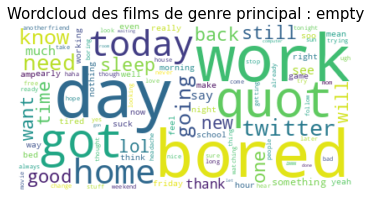

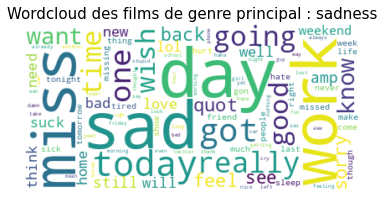

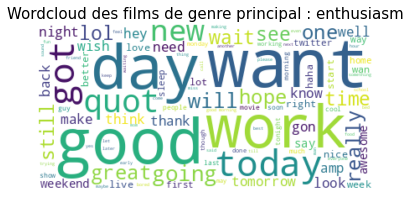

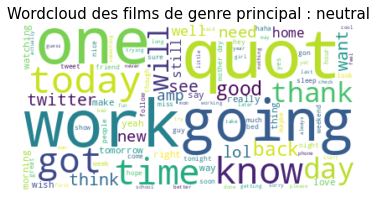

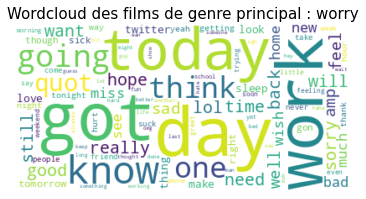

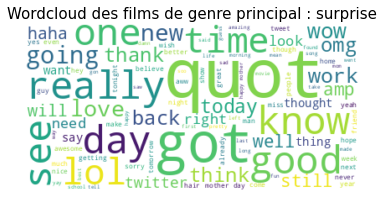

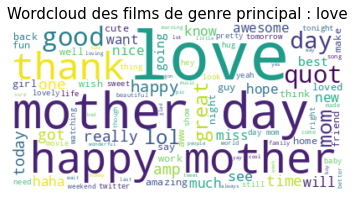

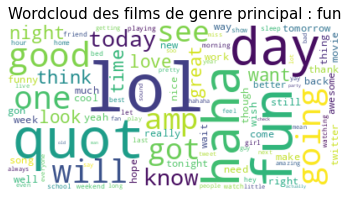

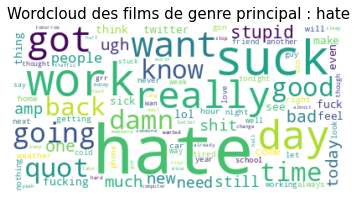

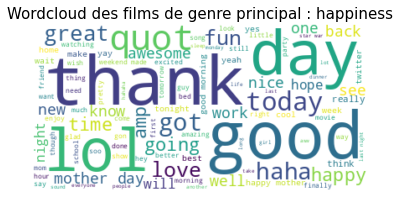

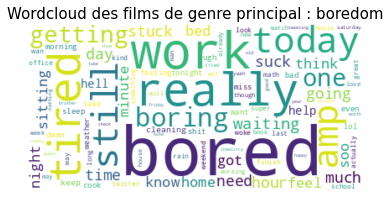

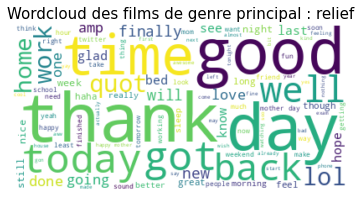

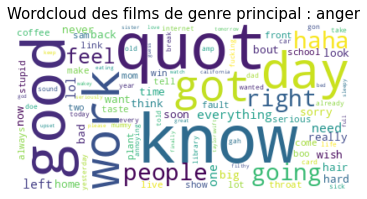

In [58]:
fontsize = 15
# Start with one review:
for i in df["sentiment"].unique():
    eap = df[df["sentiment"] == i]
    full = eap["content"]
    full = " ".join(full)
    # We tokenize the whole corpus
    # tokenizer = RegexpTokenizer("[\w']+")
    text = full
    text = text.replace("find", "")
    text = text.replace("film", "")
    # tokens = tokenizer.tokenize(text)
    # Create and generate a word cloud image:
    wordcloud = WordCloud(
        max_font_size=80, max_words=100, background_color="white"
    ).generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(
        "Wordcloud des films de genre principal : %s" % i,
        fontdict={"fontsize": fontsize},
    )
    plt.axis("off")
    plt.show()

In [59]:
arr = df.content.drop_duplicates().apply(lambda x: x.split(" ")).array
arr = [x for X in arr for x in X]
print('%s "mots" dans les content après nettoyage.' % (len(set(arr))))

41875 "mots" dans les content après nettoyage.


In [60]:
# Nombre de mots par sentiments
for sent in df["sentiment"].unique():
    arr = (
        df[df["sentiment"] == sent]
        .content.drop_duplicates()
        .apply(lambda x: x.split(" "))
        .array
    )
    arr = [x for X in arr for x in X]
    print(
        "Pour le sentiment",
        sent,
        ":",
        len(set(arr)),
        '"mots" dans les content après nettoyage.',
    )

Pour le sentiment empty : 2588 "mots" dans les content après nettoyage.
Pour le sentiment sadness : 9231 "mots" dans les content après nettoyage.
Pour le sentiment enthusiasm : 2563 "mots" dans les content après nettoyage.
Pour le sentiment neutral : 14502 "mots" dans les content après nettoyage.
Pour le sentiment worry : 13530 "mots" dans les content après nettoyage.
Pour le sentiment surprise : 5634 "mots" dans les content après nettoyage.
Pour le sentiment love : 7478 "mots" dans les content après nettoyage.
Pour le sentiment fun : 5154 "mots" dans les content après nettoyage.
Pour le sentiment hate : 3894 "mots" dans les content après nettoyage.
Pour le sentiment happiness : 10007 "mots" dans les content après nettoyage.
Pour le sentiment boredom : 830 "mots" dans les content après nettoyage.
Pour le sentiment relief : 4003 "mots" dans les content après nettoyage.
Pour le sentiment anger : 645 "mots" dans les content après nettoyage.


On voit que, à part un ou deux mots clés (comme sad, love, fun ..), les wordclouds des differents genres sont assez proche : il semble assez difficile de distinguer les differents sentiments en se basant sur les wordclouds observés. On peut donc anticiper qu'un bag of word pourrait ne pas bien marcher.

#### Loi de Zpif

In [61]:
full = df["content"]
full = " ".join(full)

# We tokenize the whole corpus
tokenizer = RegexpTokenizer("[\w']+")
text = full
tokens = tokenizer.tokenize(text)

# On compte les tokens distincts
counts, values = (
    pd.Series(tokens).value_counts().values,
    pd.Series(tokens).value_counts().index,
)
instances1 = pd.DataFrame(list(zip(values, counts)), columns=["value", "count"])

In [62]:
print("The vocabulay size is {}".format(np.shape(instances1)[0]))

instances1.head()

The vocabulay size is 41875


,value,count
0,day,3516
1,good,2327
2,you,2265
3,get,2137
4,like,1970


In [63]:
cumulative = np.cumsum(instances1["count"].tolist())
cumulative = cumulative / cumulative[-1] * 100

x = np.linspace(0, 100, len(instances1["value"].tolist()))

Text(0.5, 1.0, "Zipf's Law")

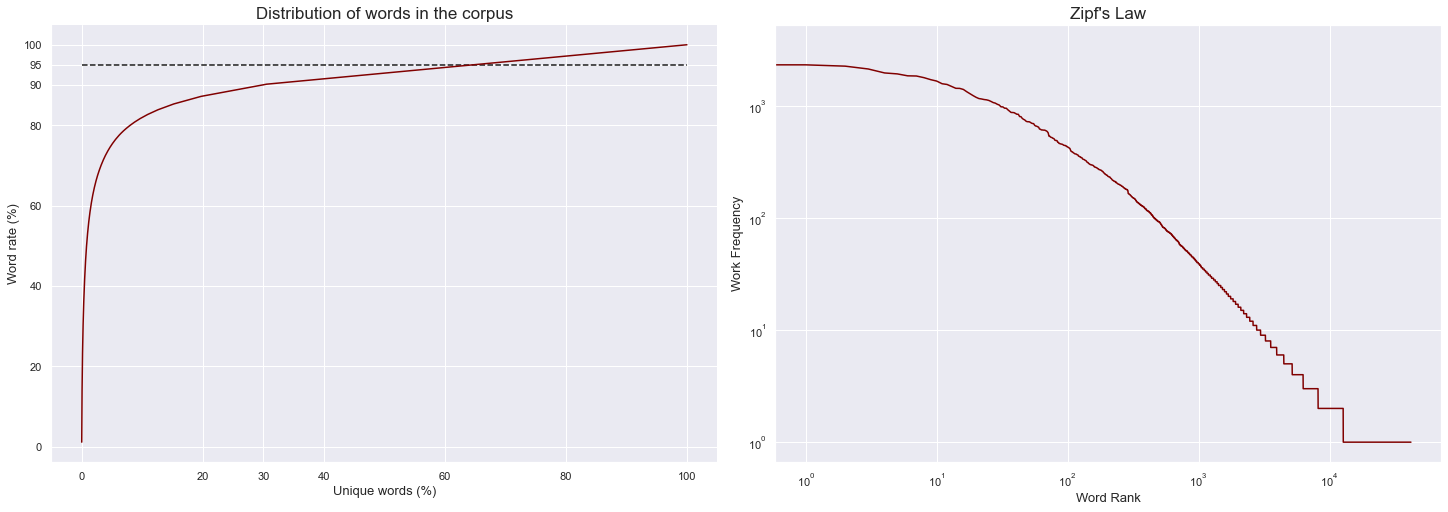

In [64]:
sns.set()

fig, (ax0, ax1) = plt.subplots(ncols=2, constrained_layout=True, figsize=(20, 7))

ax0.plot([0, 100], [95, 95], "--k")
ax0.set_yticks([0, 20, 40, 60, 80, 90, 95, 100], minor=False)
ax0.set_xticks([0, 20, 30, 40, 60, 80, 100], minor=False)
ax0.plot(x, cumulative, color="maroon")
ax0.set_xlabel("Unique words (%)", size=13)
ax0.set_ylabel("Word rate (%)", size=13)
ax0.set_title("Distribution of words in the corpus", size=17)

# removing top and right borders
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)


ax1.set_yticks([0, 20, 40, 60, 80, 90, 95, 100], minor=False)
x1 = np.arange(0, np.shape(instances1)[0], 1)
ax1.plot(x1, instances1["count"].tolist(), color="maroon")
plt.xscale("log")
plt.yscale("log")
ax1.set_xlabel("Word Rank", size=13)
ax1.set_ylabel("Work Frequency", size=13)
ax1.set_title("Zipf's Law", size=17)

On voit que 65% du vocabulaire representent 95% des mots dans les tweets tous réunis. Cela veut dire qu'on a beaucoup de mots differents, les mots se répètent peu, et cela peut potentiellement vouloir dire que cela va etre difficile d'identifier des patterns par sentiment. De plus en log-log, on voit que la courbe n'est pas linéaire donc que la loi n'est pas verifiée. Avec les stopwords on devrait avoir une loi de Zpif beaucoup plus vérifiée.

#### Proximite des sentiments

In [65]:
nltk.download("stopwords")

en_stop = set(nltk.corpus.stopwords.words("english"))
to_be_removed = list(en_stop) + list(punctuation)

tok = TweetTokenizer()
# Tokenizing + removing stopwords
text_data = list(
    df.content.apply(
        lambda x: list(
            filter(lambda a: a.lower() not in to_be_removed, tok.tokenize(x))
        )
    ).array
)
print(text_data[0])
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

ldamodel = LdaModel(corpus, id2word=dictionary, num_topics=4)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/guillaume/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['tiffanylue', 'know', 'listenin', 'bad', 'habit', 'earlier', 'started', 'freakin', 'part']


## 1.3- ProfileReport

In [230]:
#pip install pandas_profiling

In [231]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="BBC News", html={"style": {"full_width": True}})
#profile.to_notebook_iframe()

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/pandas_profiling/model/summary_algorithms.py:7: DeprecationWarning: Please use `chisquare` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import chisquare


In [68]:
l_ini = len(pd.read_csv("data/tweet_emotions.csv").drop_duplicates())
l_fin = len(pd.read_csv("data/tweets_cleaned.csv").drop_duplicates())

In [69]:
print("On a garde",round((l_fin/l_ini)*100,2),"% de la base initiale.")

On a garde 99.52 % de la base initiale.


## 1.4- Sous ensemble des sentiments

In [70]:
all_sent = df.sentiment.values
all_sent = list(all_sent)
occ_sent = Counter(all_sent)
occ_sent_sorted = dict(sorted(occ_sent.items(), key=lambda item: item[1], reverse=True))

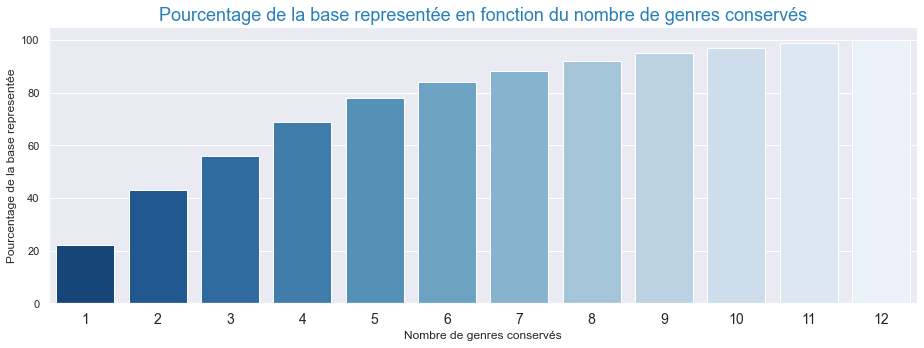

In [72]:
# Representation graphique
perc_table = []
for i in range(1, 13):
    sent_to_keep = list(occ_sent_sorted.keys())[:i]
    table_to_keep = df[df["sentiment"].isin(sent_to_keep)]
    perc_table.append(round((len(table_to_keep) / len(df)) * 100))


plt.figure(figsize=(13, 5))
ax = sns.barplot(x=list(range(1, 13)), y=perc_table, palette="Blues_r")
ax.set(xlabel="Nombre de genres conservés", ylabel="Pourcentage de la base representée")
plt.tick_params(axis="x", labelsize=14)
plt.title(
    "Pourcentage de la base representée en fonction du nombre de genres conservés",
    fontsize=18,
    color="#2980b9",
)
plt.tight_layout()
plt.show()

In [73]:
nb_sent_to_keep = 8
sent_to_keep = list(occ_sent_sorted.keys())[:nb_sent_to_keep]
table_to_keep = df[df["sentiment"].isin(sent_to_keep)]
print(
    "Pourcentage des tweets pris en compte lorsque l'on garde les",
    nb_sent_to_keep,
    " sentiments les plus frequents:",
    round((len(table_to_keep) / len(df)) * 100),
    "%",
)

Pourcentage des tweets pris en compte lorsque l'on garde les 8  sentiments les plus frequents: 92 %


In [74]:
# On garde que les 8 genres principaux :

df_8_sent = df[df["sentiment"].isin(sent_to_keep)]
print(len(df_8_sent))
df_8_sent["sentiment"].unique()

36618


array(['sadness', 'neutral', 'worry', 'surprise', 'love', 'fun',
       'happiness', 'relief'], dtype=object)

In [75]:
df_8_sent.to_csv("data/tweets_cleaned_8_sentiments.csv")

----------------------------------------------------------------------------------------------

# 2 - Modélisation: classification multiclasse single label

#### Fonctions pour l'evaluation des modeles

In [32]:
def get_label_encoder_obj(y):
    label_encoder = LabelEncoder()
    return label_encoder.fit(y)


def get_y_label_encoder(label_encoder, y):
    return label_encoder.transform(y)


def get_label_decoder(label_encoder, y):
    return label_encoder.classes_[y]


def one_hot_encode(y, num_classes):
    return to_categorical(y, num_classes=num_classes)


from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle


def ROC_plot(y_true_ohe, y_hat_ohe, label_encoder, n_classes):
    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_ohe[:, i], y_hat_ohe[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_ohe.ravel(), y_hat_ohe.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(20, 20))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(
                label_encoder.classes_[i], roc_auc[i]
            ),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("multiclass characteristic")
    plt.legend(loc="lower right")
    plt.show()


from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
)
from sklearn.metrics import f1_score as f1_score_rep
import seaborn as sn


def print_score(y_pred, y_real, label_encoder):
    print("Accuracy: ", accuracy_score(y_real, y_pred))
    print("Precision:: ", precision_score(y_real, y_pred, average="micro"))
    print("Recall:: ", recall_score(y_real, y_pred, average="micro"))
    print("F1_Score:: ", f1_score_rep(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (macro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="macro"))

    print()
    print("Macro precision_recall_fscore_support (micro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (weighted) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="weighted"))

    print()
    print("Confusion Matrix")
    cm = confusion_matrix(y_real, y_pred)
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(
        cm,
        index=[i for i in label_encoder.classes_],
        columns=[i for i in label_encoder.classes_],
    )
    plt.figure(figsize=(20, 20))
    sn.heatmap(df_cm, annot=True)

    print()
    print("Classification Report")
    print(classification_report(y_real, y_pred, target_names=label_encoder.classes_))


# Ces fonctions nous permettent d'évaluer nos modèles


def f_scoring(model, score):
    evaluation = cross_val_score(
        model, X, y, cv=StratifiedKFold(n_splits=3, shuffle=True), scoring=score
    ).mean()
    return evaluation


# For prediction of genre_principal
def conf_matrix(y_true, y_pred, title):
    C = confusion_matrix(y_true, y_pred)

    ConfMatrix = C / C.sum(axis=1)[:, None]

    plt.figure(figsize=(10, 5))
    ax = sns.heatmap(
        ConfMatrix,
        annot=True,
        cmap="Reds",
        fmt=".2f",
        xticklabels=["1", "2", "3", "4", "5", "6", "7"],
        yticklabels=["1", "2", "3", "4", "5", "6", "7"],
    )

    sns.set()

    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top)

    plt.xlabel("Predicted Class", fontsize=12)
    plt.ylabel("True Class", fontsize=12)
    # plt.title("Confusion Matrix", size = 14)
    plt.savefig(title + ".pdf")

    return plt.show()


def plot(estimator, title):
    fig, ax = plt.subplots(1, 2, figsize=(17, 5))

    sns.set()  # Reset seaborn settings to get rid of black background

    ax[0].plot(
        np.arange(1, len(estimator.history["acc"]) + 1, 1),
        estimator.history["acc"],
        "o-",
        color="firebrick",
    )
    ax[0].plot(
        np.arange(1, len(estimator.history["val_acc"]) + 1, 1),
        estimator.history["val_acc"],
        "o-",
        color="forestgreen",
    )
    ax[0].set_title("Model Accuracy")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("Epoch")
    ax[0].legend(["Train", "Valid"], loc="upper left")
    ax[0].grid(ls="dashed")

    # Plot model loss over epochs
    ax[1].plot(
        np.arange(1, len(estimator.history["loss"]) + 1, 1),
        estimator.history["loss"],
        "o-",
        color="firebrick",
    )
    ax[1].plot(
        np.arange(1, len(estimator.history["val_loss"]) + 1, 1),
        estimator.history["val_loss"],
        "o-",
        color="forestgreen",
    )
    ax[1].set_title("Model Loss")
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("Epoch")
    ax[1].legend(["Train", "Valid"], loc="upper left")
    ax[1].grid(ls="dashed")
    plt.savefig( title + ".pdf")

    return

## 2.1. Classification sur les 8 sentiments principaux

### 2.1.1 - Modèle de machine learning (~baseline)

In [62]:
df = pd.read_csv("tweets_cleaned_8_sentiments.csv")
print(len(df))
df = df.dropna()
print(len(df))

36618
36618


In [63]:
train, val = train_test_split(
    df, test_size=0.2, random_state=2, stratify=df["sentiment"]
)

label_encoder = get_label_encoder_obj(train["sentiment"])
train["sentiment"] = get_y_label_encod@er(label_encoder, train["sentiment"])
val["sentiment"] = get_y_label_encoder(label_encoder, val["sentiment"])

X_train = train["content"].values
y_train = train["sentiment"].values
X_val = val["content"].values
y_val = val["sentiment"].values

In [64]:
label_encoder.classes_

array(['fun', 'happiness', 'love', 'neutral', 'relief', 'sadness',
       'surprise', 'worry'], dtype=object)

#### Baseline model : Bag of words et tf-idf avec des modeles de classifieurs : Random Forest ...

In [18]:
def CountVectorizer_fit(X_train, ngram_range=(1, 1)):
    count_vect = CountVectorizer(ngram_range=ngram_range)
    return count_vect.fit(X_train)


def CountVectorizer_transform(count_vect, X):
    return count_vect.transform(X)


def TfidfTransformer_fit(X_train_counts, use_idf=True):
    tf_transformer = TfidfTransformer(use_idf=use_idf)
    return tf_transformer.fit(X_train_counts)


def TfidfTransformer_transform(tf_transformer, X_counts):
    return tf_transformer.transform(X_counts)


count_vect = CountVectorizer_fit(X_train, ngram_range=(1, 3))
X_train_counts = CountVectorizer_transform(count_vect, X_train)
X_val_counts = CountVectorizer_transform(count_vect, X_val)

tf_transformer = TfidfTransformer_fit(X_train_counts)
X_train_tfidf = TfidfTransformer_transform(tf_transformer, X_train_counts)
X_val_tfidf = TfidfTransformer_transform(tf_transformer, X_val_counts)

In [82]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=5)]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=5)]
max_depth.append(None)
# Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
grid_params_rf = {
    "n_estimators": n_estimators,
    #'max_features': max_features,
    #'max_depth': max_depth,
    #'min_samples_split': min_samples_split,
    #'min_samples_leaf': min_samples_leaf,
    "bootstrap": bootstrap,
}

%time
grid_params_sgd = {
    "loss": ["hinge", "log", "modified_huber"],
    "penalty": ["l1", "l2", "elasticnet"],
    "alpha": [1e-5],
    "max_iter": [100],
}

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 11 µs


In [83]:
classifiers = {
    "Random Forest": RandomForestClassifier(),  # max_depth=5, n_estimators=10, max_features=1
    # "Neural Net":MLPClassifier(alpha=1, max_iter=1000),
    "AdaBoost": AdaBoostClassifier(),
    "sgdclassifier": SGDClassifier(),
}

In [84]:
classifier = classifiers["sgdclassifier"]

In [85]:
grid = GridSearchCV(classifier, grid_params_sgd, refit=True, cv=3, verbose=1)
grid.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=SGDClassifier(),
             param_grid={'alpha': [1e-05],
                         'loss': ['hinge', 'log', 'modified_huber'],
                         'max_iter': [100],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             verbose=1)

In [86]:
print(grid.best_params_)
print(grid.best_estimator_)

{'alpha': 1e-05, 'loss': 'log', 'max_iter': 100, 'penalty': 'l1'}
SGDClassifier(alpha=1e-05, loss='log', max_iter=100, penalty='l1')


In [87]:
num_classes = 8

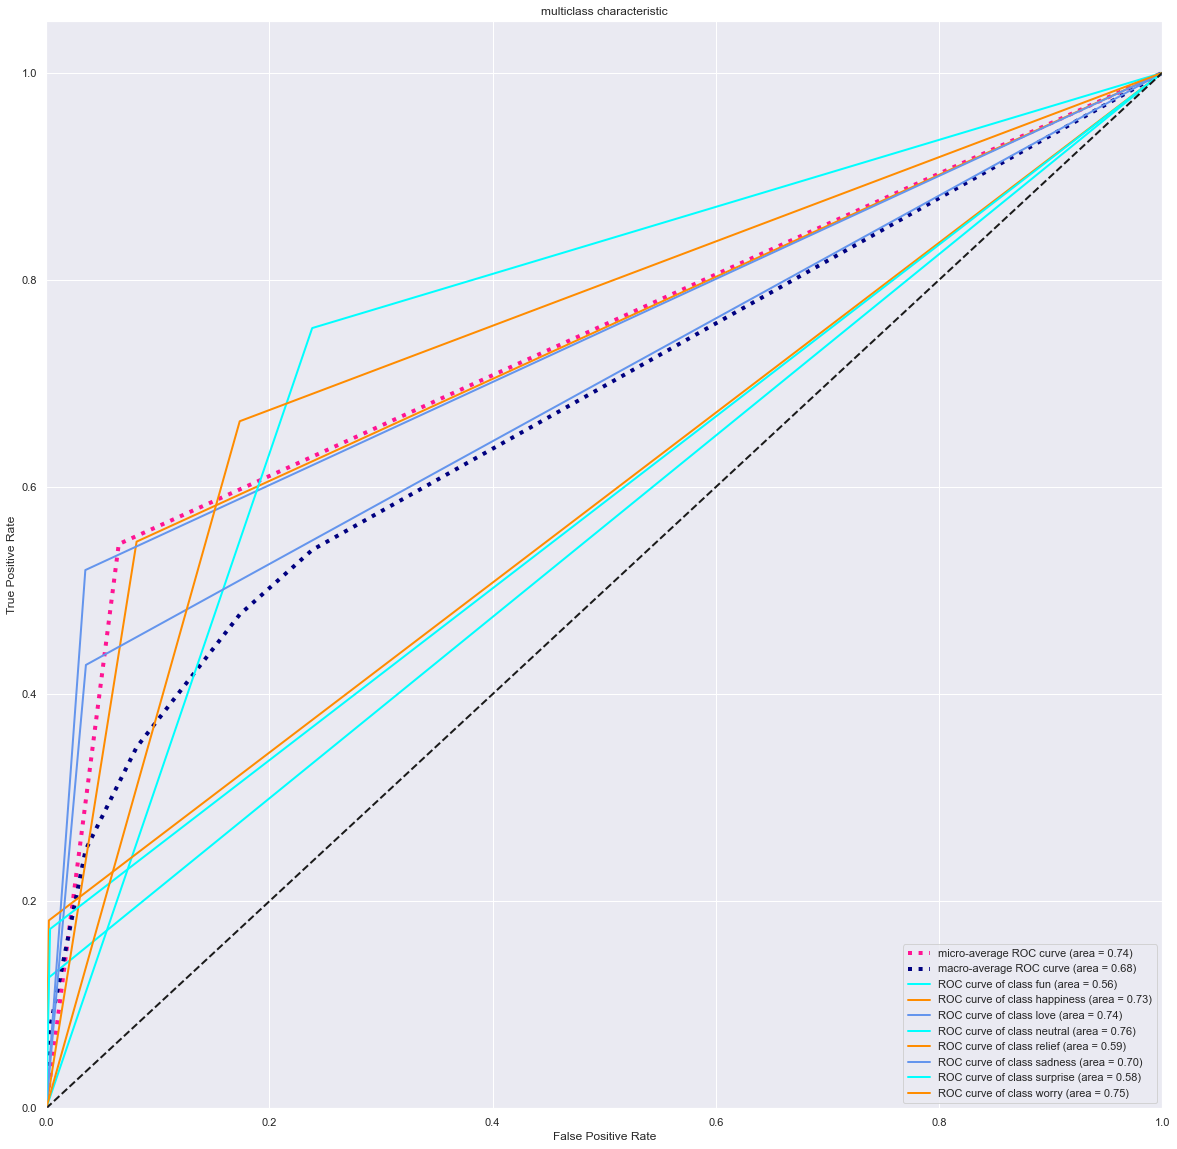

Accuracy:  0.5449238751962859
Precision::  0.5449238751962859
Recall::  0.5449238751962859
F1_Score::  0.5449238751962859

Macro precision_recall_fscore_support (macro) average
(0.6406390045122667, 0.4241288416532827, 0.4507050826426479, None)

Macro precision_recall_fscore_support (micro) average
(0.5449238751962859, 0.5449238751962859, 0.5449238751962859, None)

Macro precision_recall_fscore_support (weighted) average
(0.5849613851724829, 0.5449238751962859, 0.5234460290415398, None)

Confusion Matrix

Classification Report
              precision    recall  f1-score   support

         fun       0.75      0.13      0.22      1420
   happiness       0.53      0.55      0.54      4146
        love       0.63      0.52      0.57      3028
     neutral       0.49      0.75      0.60      6869
      relief       0.77      0.18      0.29      1218
     sadness       0.66      0.43      0.52      4122
    surprise       0.76      0.17      0.28      1744
       worry       0.53      0.66  

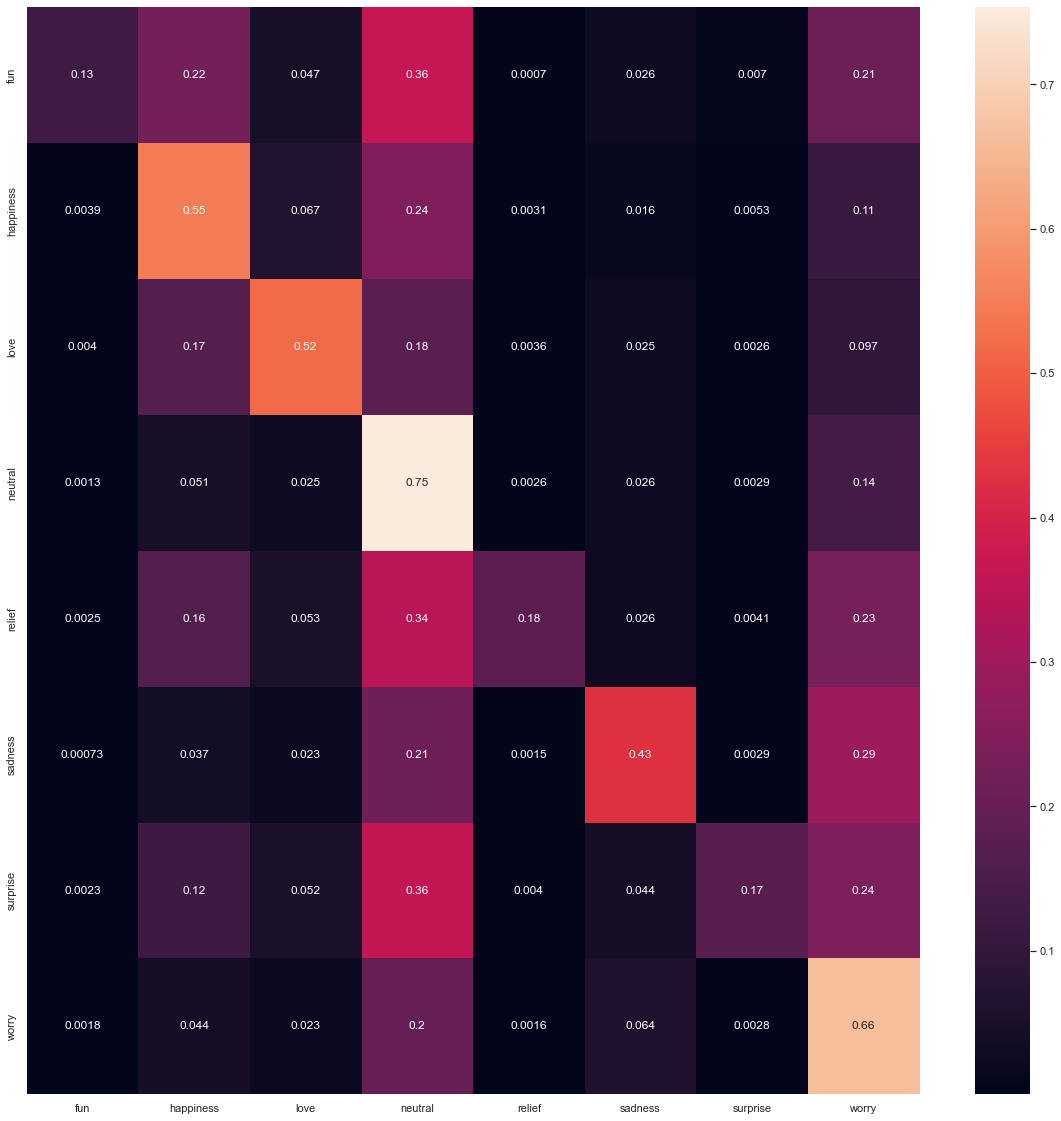

In [88]:
y_hat = grid.best_estimator_.predict(X_train_tfidf)
y_train_ohe = one_hot_encode(y_train, num_classes)
y_hat_ohe = one_hot_encode(y_hat, num_classes)
ROC_plot(y_train_ohe, y_hat_ohe, label_encoder, num_classes)
print_score(y_hat, y_train, label_encoder)

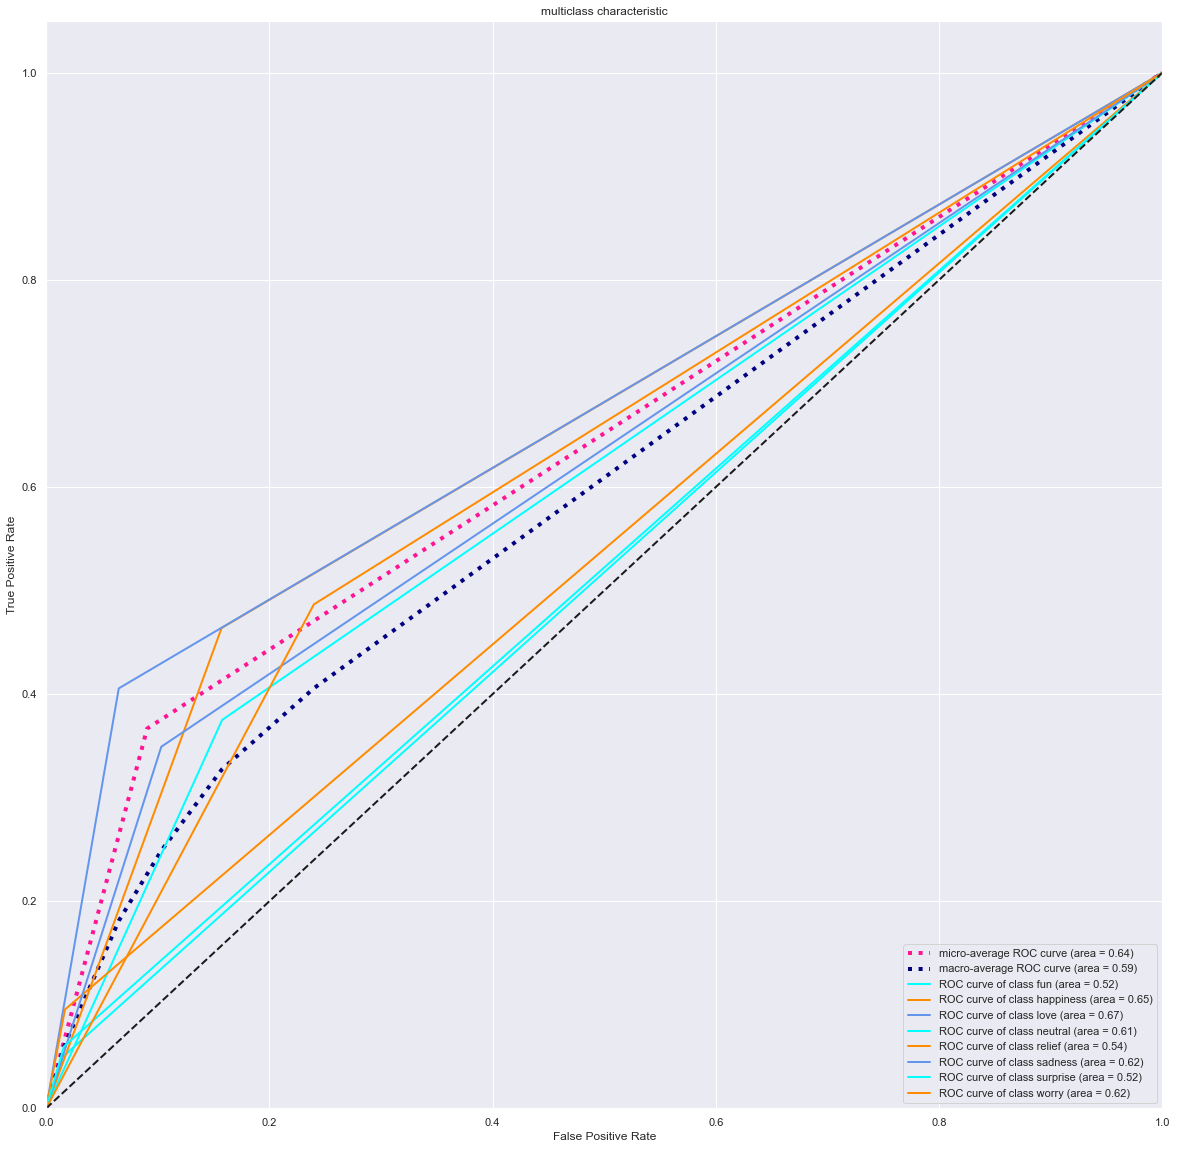

Accuracy:  0.3667394866193337
Precision::  0.3667394866193337
Recall::  0.3667394866193337
F1_Score::  0.3667394866193337

Macro precision_recall_fscore_support (macro) average
(0.30389621241517734, 0.28575365932038904, 0.2831228166950716, None)

Macro precision_recall_fscore_support (micro) average
(0.3667394866193337, 0.3667394866193337, 0.3667394866193337, None)

Macro precision_recall_fscore_support (weighted) average
(0.3520662411649908, 0.3667394866193337, 0.35199969113308077, None)

Confusion Matrix

Classification Report
              precision    recall  f1-score   support

         fun       0.14      0.05      0.07       355
   happiness       0.33      0.46      0.38      1037
        love       0.42      0.41      0.41       757
     neutral       0.42      0.38      0.40      1717
      relief       0.20      0.10      0.13       304
     sadness       0.36      0.35      0.35      1031
    surprise       0.19      0.06      0.09       436
       worry       0.38      0.4

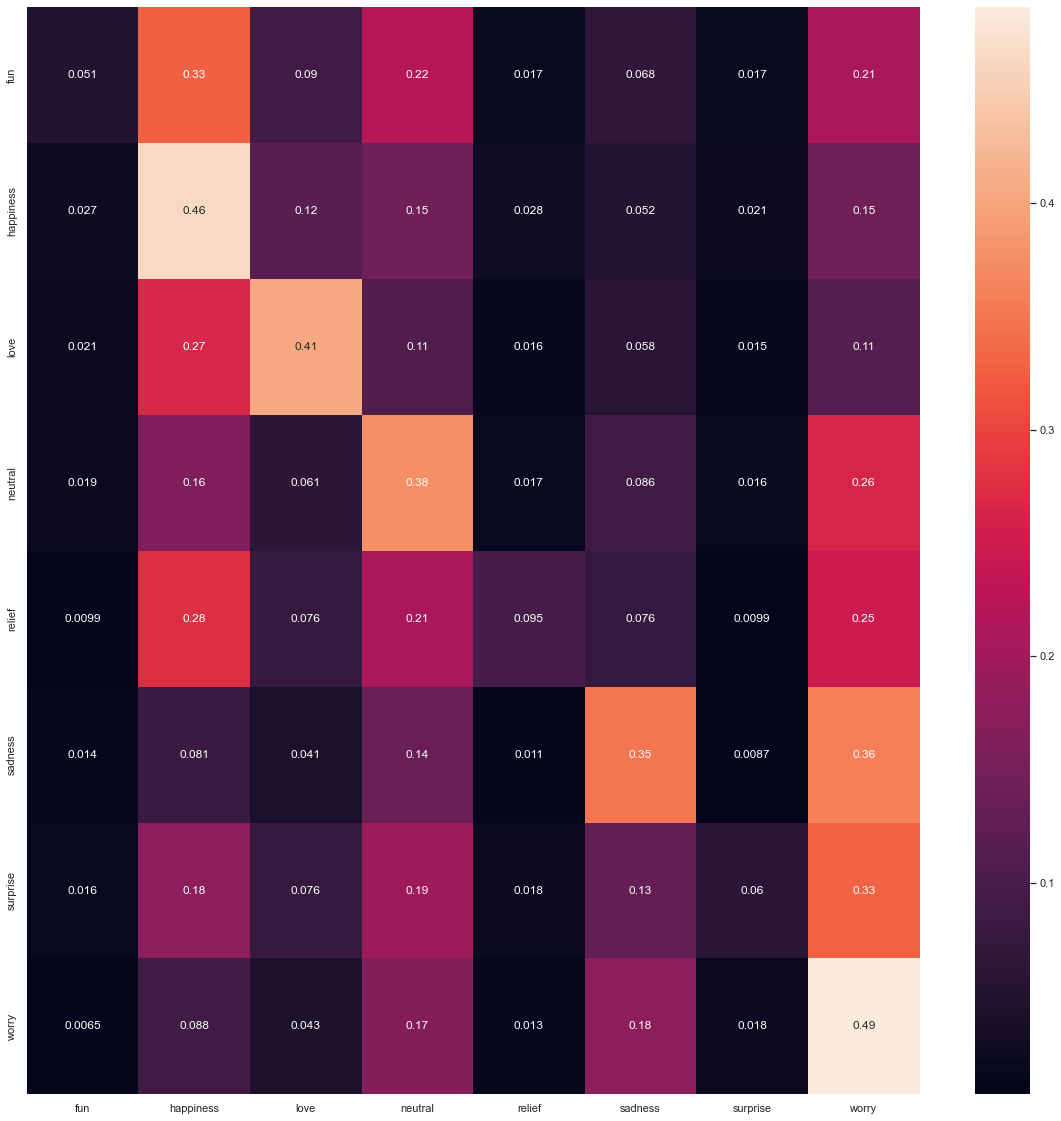

In [89]:
y_hat = grid.best_estimator_.predict(X_val_tfidf)
y_val_ohe = one_hot_encode(y_val, num_classes)
y_hat_ohe = one_hot_encode(y_hat, num_classes)
ROC_plot(y_val_ohe, y_hat_ohe, label_encoder, num_classes)
print_score(y_hat, y_val, label_encoder)

### 2.1.2 - Modèle de deep learning 

#### Fasttext embeddings + LSTM

In [3]:
df = pd.read_csv("tweets_cleaned_8_sentiments.csv", index_col=0)
print(len(df))
df = df.dropna()
print(len(df))

36618
36618


In [4]:
df["tokens"] = df["tokens"].apply(literal_eval)
X, y = np.array(df["content"]), np.array(df["sentiment"])

# Transform labels into one hot encoded format.
y_bin = label_binarize(df["sentiment"], classes=list(df["sentiment"].unique()))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, train_size=0.8, random_state=42, stratify=y
)

In [24]:
# fasttext vectors can be imported through torch text (it will download it only once)
from gensim.models.fasttext import FastText

text_dim = 100

print("Training FastText model...")

ftext_model = FastText(
    list(df["tokens"]), vector_size=100, window=40, min_count=1, workers=4, sg=1
)

print("FastText model created.")
print(
    "%d unique words represented by %d dimensional vectors"
    % (len(ftext_model.wv.key_to_index), text_dim)
)

Training FastText model...
FastText model created.
39386 unique words represented by 100 dimensional vectors


In [25]:
# save model in ASCII (word2vec) format
filename = "tweets_embedding_fasttext.txt"
ftext_model.wv.save_word2vec_format(filename, binary=False)

In [5]:
# load embedding from file
# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename, "r")
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype="float32")
    return embedding


raw_embedding = load_embedding("tweets_embedding_fasttext.txt")

In [6]:
class transformer_data_deep(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, df):
        encoded_docs = self.t.texts_to_sequences(np.array(df))
        # max_length = max([len(s) for s in encoded_docs])
        max_length = 60
        return pad_sequences(encoded_docs, maxlen=max_length, padding="post")

    def fit(self, df_train, y=None):
        self.t = Tokenizer()
        self.t.fit_on_texts(np.array(df_train))
        return self

        # create a weight matrix for the Embedding layer from a loaded embedding

    def get_weight_matrix(self, embedding):
        vocab = self.t.word_index
        # total vocabulary size plus 0 for unknown words
        vocab_size = len(vocab) + 1
        # define weight matrix dimensions with all 0
        weight_matrix = np.zeros((vocab_size, 100))
        # step vocab, store vectors using the Tokenizer's integer mapping
        for word, i in vocab.items():
            weight_matrix[i] = embedding.get(word)
        return weight_matrix, vocab_size

In [7]:
transform = transformer_data_deep()
transform.fit(X_train)
X_train_input = transform.transform(X_train)
X_test_input = transform.transform(X_test)

In [31]:
kernel_size = 5
pool_size = 4
maxlen = 22


def build_model(raw_embedding):

    embedding_dim = 100
    inp = Input(shape=(maxlen,))

    # get vectors in the right order
    embedding_vectors, vocab_size = transform.get_weight_matrix(raw_embedding)

    x = Embedding(
        vocab_size,
        100,
        weights=[embedding_vectors],
        input_length=maxlen,
        trainable=False,
    )(inp)
    x = SpatialDropout1D(0.3)(x)

    x = Bidirectional(
        LSTM(32, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)
    )(x)
    x = Conv1D(
        filters=32,
        kernel_size=5,
        padding="valid",
        activation="elu",
        strides=1,
        kernel_initializer="glorot_uniform",
    )(x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    preds = Dense(8, activation="softmax")(conc)

    model = Model(inputs=inp, outputs=preds)
    opt = tf.keras.optimizers.Adam(learning_rate=0.002)
    loss = tf.keras.losses.CategoricalCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM
    )
    model.compile(loss=loss, optimizer=opt, metrics=["acc"])
    return model

In [32]:
model = build_model(raw_embedding)
model.summary()

2022-04-23 13:33:06.960548: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-23 13:33:06.960590: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-23 13:33:06.960619: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-04-23 13:33:06.960858: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 22)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 22, 100)      3352000     ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 22, 100)     0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 22, 64)       34048       ['spatial_dropout1d[0][0]']  

In [33]:
estimator_fastext = model.fit(
    X_train_input[:, :22],
    y_train,
    epochs = 40,
    validation_data = (X_test_input[:, :22], y_test),
)

Epoch 1/40
916/916 [==============================] - 36s 33ms/step - loss: 59.4523 - acc: 0.2851 - val_loss: 58.6475 - val_acc: 0.3168
Epoch 2/40
916/916 [==============================] - 30s 32ms/step - loss: 57.7952 - acc: 0.3201 - val_loss: 56.5583 - val_acc: 0.3392
Epoch 3/40
916/916 [==============================] - 30s 32ms/step - loss: 57.0701 - acc: 0.3312 - val_loss: 55.9614 - val_acc: 0.3605
Epoch 4/40
916/916 [==============================] - 30s 33ms/step - loss: 56.6453 - acc: 0.3365 - val_loss: 55.6678 - val_acc: 0.3622
Epoch 5/40
916/916 [==============================] - 30s 33ms/step - loss: 56.3813 - acc: 0.3391 - val_loss: 55.6822 - val_acc: 0.3536
Epoch 6/40
916/916 [==============================] - 30s 33ms/step - loss: 56.2087 - acc: 0.3413 - val_loss: 55.3952 - val_acc: 0.3610
Epoch 7/40
916/916 [==============================] - 30s 33ms/step - loss: 55.9409 - acc: 0.3443 - val_loss: 55.1785 - val_acc: 0.3606
Epoch 8/40
916/916 [============================

In [34]:
print(
    "Training accuracy: %.2f%% / Validation accuracy: %.2f%%"
    % (
        100 * estimator_fastext.history["acc"][-1],
        100 * estimator_fastext.history["val_acc"][-1],
    )
)

Training accuracy: 37.98% / Validation accuracy: 36.31%


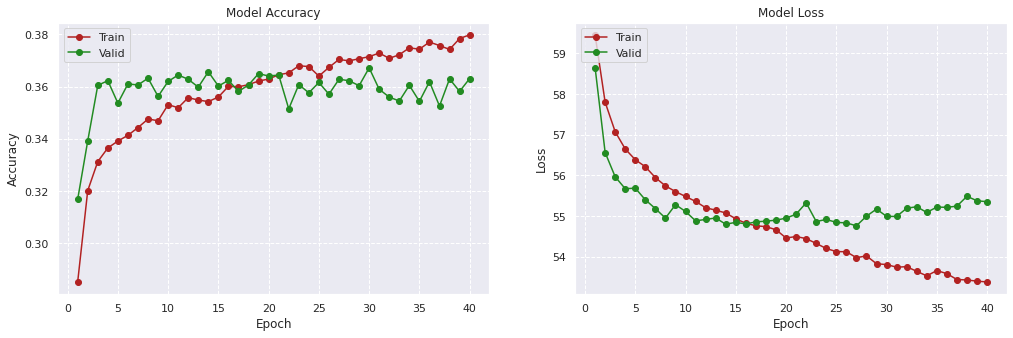

In [37]:
plot(estimator_fastext, "lstm_direct_embed")

In [38]:
y_prob = model.predict(X_test_input[:, :22])
y_pred = y_prob.argmax(axis=-1) + 1

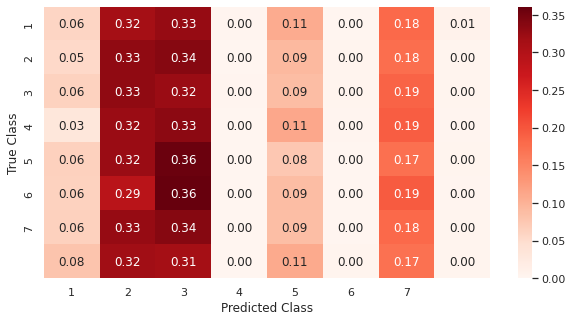

In [39]:
labels_train, labels_test = train_test_split(
    df["sentiment"], test_size=0.2, random_state=42
)
d = {
    "sadness": 1,
    "neutral": 2,
    "worry": 3,
    "surprise": 4,
    "love": 5,
    "fun": 6,
    "happiness": 7,
    "relief": 8,
}

labels_test_code = [d[gen] for gen in labels_test]
conf_matrix(labels_test_code, y_pred, "conf_matrix_direct_embed")

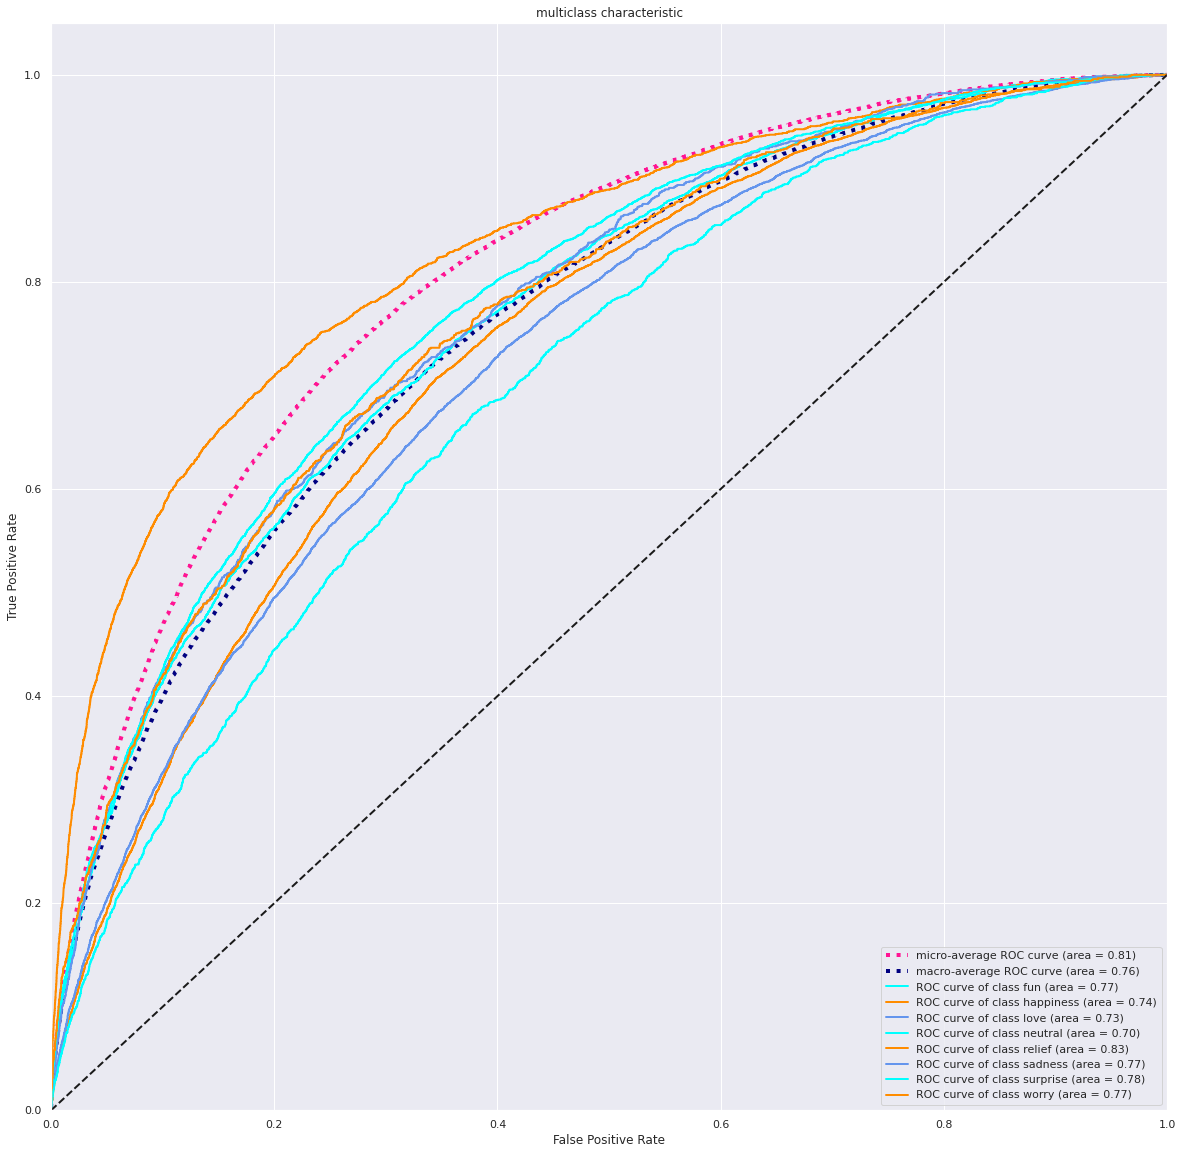

In [47]:
label_encoder = get_label_encoder_obj(df["sentiment"].unique())
num_classes = 8
y_hat = model.predict(X_train_input[:, :22])
ROC_plot(y_train, y_hat, label_encoder, num_classes)

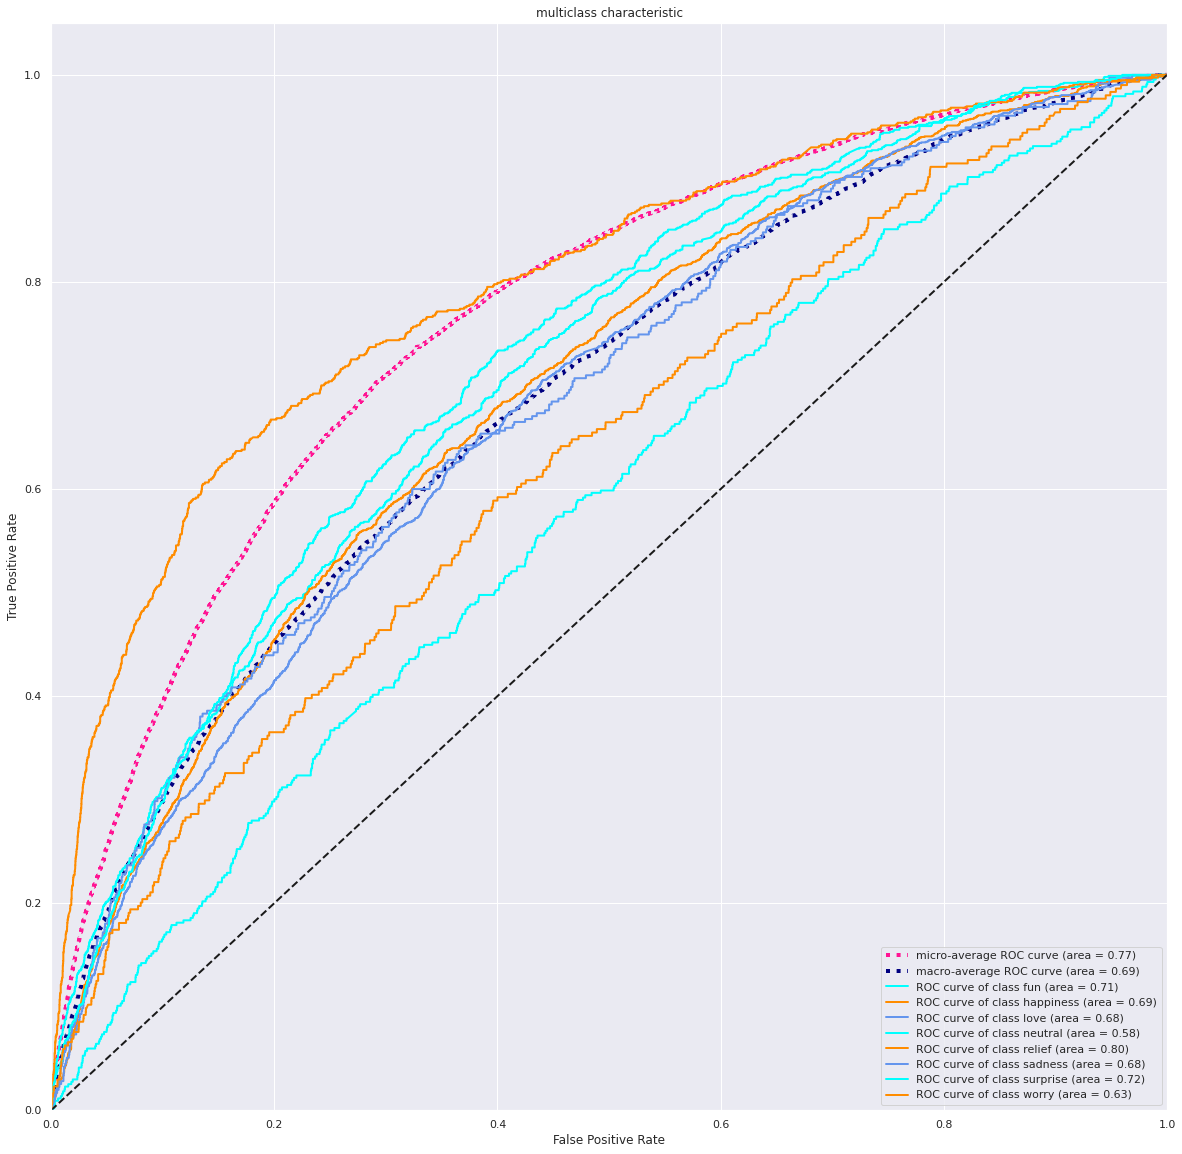

In [60]:
num_classes = 8
y_hat = model.predict(X_test_input[:, :22])
ROC_plot(y_test, y_hat, label_encoder, num_classes)

### 2.1.3 - Data Augmentation

In [3]:
from transformers import MarianMTModel, MarianTokenizer

# Get the name of the first model
first_model_name = 'Helsinki-NLP/opus-mt-en-fr'

# Get the tokenizer
first_model_tkn = MarianTokenizer.from_pretrained(first_model_name)

# Load the pretrained model based on the name
first_model = MarianMTModel.from_pretrained(first_model_name)

In [4]:
# Get the name of the second model
second_model_name = 'Helsinki-NLP/opus-mt-fr-en'

# Get the tokenizer
second_model_tkn = MarianTokenizer.from_pretrained(second_model_name)

# Load the pretrained model based on the name
second_model = MarianMTModel.from_pretrained(second_model_name)

In [5]:
def format_batch_texts(language_code, batch_texts):
    formated_bach = [">>{}<< {}".format(language_code, text) for text in batch_texts]
    return formated_bach

In [6]:
def perform_translation(batch_texts, model, tokenizer, language="fr"):
    # Prepare the text data into appropriate format for the model
    formated_batch_texts = format_batch_texts(language, batch_texts)
    
    # Generate translation using model
    translated = model.generate(**tokenizer(formated_batch_texts, return_tensors="pt", padding=True))
    # Convert the generated tokens indices back into text
    #translated_texts = []
    #i = 0
    #for t in translated:
    #    i+=1
    #    translated_texts.append(tokenizer.decode(t, skip_special_tokens=True))
    #    if i%2 == 0:
    #        print(round((i/len(translated))*100),"% des textes sont traduits.")
    #    else:
    #        continue
    
    translated_texts = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]
    
    return translated_texts

In [7]:
def combine_texts(original_texts, back_translated_batch):
    return set(original_texts + back_translated_batch)

def perform_back_translation_with_augmentation(batch_texts, original_language="en", temporary_language="fr"):
    # Translate from Original to Temporary Language
    print("Performing translation to french")
    tmp_translated_batch = perform_translation(batch_texts, first_model, first_model_tkn, temporary_language)
    #print(tmp_translated_batch)
    # Translate Back to English
    print("Performing translation back to english")
    back_translated_batch = perform_translation(tmp_translated_batch, second_model, second_model_tkn, original_language)
    #return back_translated_batch
    #Return The Final Result
    #print(back_translated_batch)
    return list(combine_texts(batch_texts, back_translated_batch))

# Execute the function for Data Augmentation
#final_augmented = perform_back_translation_with_augmentation(original_texts)
#print(final_augmented)

In [8]:
df = pd.read_csv("tweets_cleaned_8_sentiments.csv").drop(['Unnamed: 0'],1)
df = df[['sentiment','tweet']]

/tmp/ipykernel_889/769594035.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = pd.read_csv("tweets_cleaned_8_sentiments.csv").drop(['Unnamed: 0'],1)


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


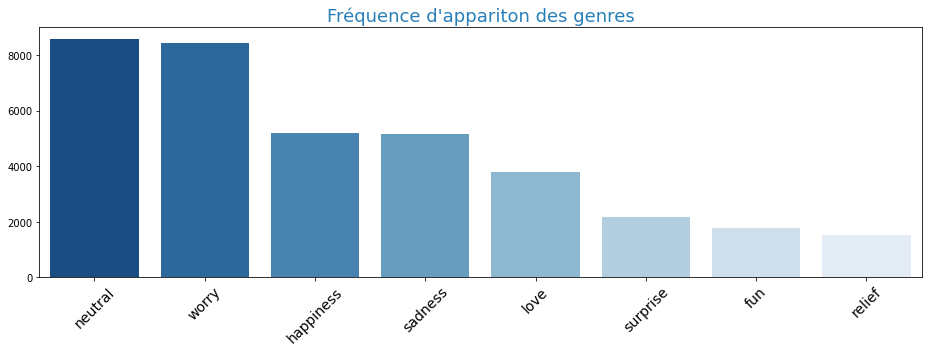

In [9]:
all_genres = df.sentiment.values
all_genres = list(all_genres)
occ_genres = Counter(all_genres)
occ_genres_sorted = dict(sorted(occ_genres.items(), key=lambda item: item[1],reverse=True))

plt.figure(figsize = (13,5))
sns.barplot(list(occ_genres_sorted.keys()),list(occ_genres_sorted.values()),palette="Blues_r")
plt.tick_params(axis = 'x', labelsize = 14)
plt.title("Fréquence d'appariton des genres", fontsize=18, color='#2980b9')
plt.xticks(rotation= 45)
plt.tight_layout()

In [10]:
sentiment = 'relief'

In [ ]:
to_dataaugm = list(df[df['sentiment']==sentiment]['tweet'])
print("On va augmenter",len(to_dataaugm),"tweets du genre",genre,".")
splits = np.array_split(to_dataaugm, 10)
nb_l = len(splits)
i = 0
data_augm_df = pd.DataFrame(columns=['overview_augmented'])
for split in splits:
    print("--Calculs des",round((i/nb_l)*100),"% des tweets à augmenter :--")
    bis = pd.DataFrame(columns=['overview_augmented'])
    i+=1 
    split = list(split)
    data_augm = perform_back_translation_with_augmentation(split)
    print('--',round((i/nb_l)*100),"des tweets sont traités.--")
    bis['overview_augmented'] = data_augm
    data_augm_df = pd.concat([data_augm_df,bis])
    data_augm_df.to_csv("data_augmented_%s.csv"%genre)
    
data_augm_df['sentiment'] = genre
data_augm_df = data_augm_df.reset_index()
data_augm_df = data_augm_df.drop(['index'],1)
data_augm_df.to_csv("Data augmented/data_augmented_%s.csv"%genre)

On va augmenter 1522 films du genre relief .
--Calculs des 0 % des films à augmenter :--
Performing translation to french
Performing translation back to english


## 2.4 - Modele pré-entrainé d'analyse de sentiments

In [39]:
df = pd.read_csv("tweets_cleaned_8_sentiments.csv", index_col=0)
label_encoder = get_label_encoder_obj(df["sentiment"].unique())

positive_sentiments = ["love", "fun", "happiness"]
negative_sentiments = ["worry", "sadness"]
neutral_sentiments = ["neutral", "suprise", "relief"]

df_binary = df[~df.sentiment.isin(neutral_sentiments)]

In [7]:
binary_sentiments = df_binary.sentiment.apply(
    lambda x: "POSITIVE" if x in positive_sentiments else "NEGATIVE"
)
df_binary = df_binary.assign(binary_sentiments=binary_sentiments)

In [31]:
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
2022-04-21 22:35:43.412020: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-21 22:35:43.465640: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was

In [48]:
# As it take a long time to predict we do it on a subset
df_subset = df_binary.sample(1000, random_state=42)

# Get the string to classify
input_content = list(df_subset.content.values)

df_pred = pd.DataFrame(sentiment_pipeline(input_content))

In [49]:
pred = df_pred.label.values
true = df_subset.binary_sentiments.values

res = np.mean(true == pred) * 100
print(f'The model guess right {int(res)}% of binary sentiments.')

The model guess right 70% of binary sentiments.


#### Finetuning for all sentiments

In [57]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig, TFAutoModelWithLMHead, TFAutoModel, AutoModel

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

classifier = pipeline('sentiment-analysis')

import random
random.seed(42)
##### SET UP THE MODEL #####
save_directory = "distilbert-base-uncased"
config = DistilBertConfig(dropout=0.3, attention_dropout=0.3)
config.output_hidden_states = False
transformer_model = TFAutoModel.from_pretrained(save_directory, from_pt=True, config = config)

##### LOAD THE TEST DATA #####
map_sentiment = {sentiment: i for i, sentiment in enumerate(df.sentiment.unique())}

df_dataset = df.replace({"sentiment": map_sentiment}).rename(
    columns={"sentiment": "label", "content": "text"}
)[["text", "label"]]
X_train, X_test, y_train, y_test = train_test_split(df["content"], df["sentiment"], test_size=0.20, random_state=42)
# Create X values
tokenizer = AutoTokenizer.from_pretrained(save_directory)
X_train = tokenizer(
     list(X_train),
     padding=True,
     truncation=True,
     return_tensors="tf",
     max_length = 45
 )

X_test = tokenizer(
     list(X_test),
     padding=True,
     truncation=True,
     return_tensors="tf",
     max_length = 45
 )
# Create Y values
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the

In [56]:
input_ids_in = tf.keras.layers.Input(shape=(45,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(45,), name='masked_token', dtype='int32') 
# Build model that will go on top of DistilBERT
embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation='relu')(X)
X = tf.keras.layers.Dropout(0.3)(X)
X = tf.keras.layers.Dense(8, activation='sigmoid')(X)
tf.keras.layers.Softmax(axis=-1)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False
    
loss = tf.keras.losses.CategoricalCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM
    )


model.compile(optimizer="Adam", loss=loss, metrics=["acc"])
    

history = model.fit([X_train["input_ids"],   X_train["attention_mask"]], 
          y_train, 
          batch_size=128, 
          epochs=15, 
          verbose=1, 
          validation_data=([X_test["input_ids"],   X_test["attention_mask"]], 
          y_test))
#### SAVE WEIGHTS FOR LATER ####
model.save_weights('bert2_only')

Epoch 1/15
229/229 [==============================] - 935s 4s/step - loss: 235.0997 - acc: 0.2995 - val_loss: 224.6843 - val_acc: 0.3458
Epoch 2/15
229/229 [==============================] - 924s 4s/step - loss: 225.2120 - acc: 0.3444 - val_loss: 220.5837 - val_acc: 0.3594
Epoch 3/15
229/229 [==============================] - 923s 4s/step - loss: 222.6343 - acc: 0.3513 - val_loss: 217.8168 - val_acc: 0.3652
Epoch 4/15
229/229 [==============================] - 923s 4s/step - loss: 220.5922 - acc: 0.3612 - val_loss: 216.1080 - val_acc: 0.3719
Epoch 5/15
229/229 [==============================] - 923s 4s/step - loss: 219.3512 - acc: 0.3674 - val_loss: 214.4585 - val_acc: 0.3729
Epoch 6/15
229/229 [==============================] - 922s 4s/step - loss: 217.8239 - acc: 0.3695 - val_loss: 213.5439 - val_acc: 0.3775
Epoch 7/15
229/229 [==============================] - 922s 4s/step - loss: 216.9011 - acc: 0.3711 - val_loss: 213.2207 - val_acc: 0.3783
Epoch 8/15
229/229 [=====================

In [58]:
print(
    "Training accuracy: %.2f%% / Validation accuracy: %.2f%%"
    % (
        100 *history.history["acc"][-1],
        100 * history.history["val_acc"][-1],
    )
)

Training accuracy: 38.97% / Validation accuracy: 38.60%


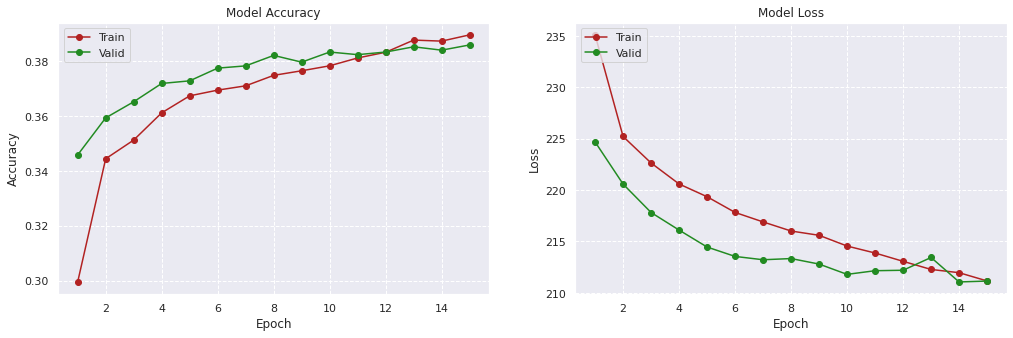

In [59]:
plot(history, "bert_embed")

In [60]:
y_prob = model.predict([X_test["input_ids"],   X_test["attention_mask"]])
y_pred = y_prob.argmax(axis=-1) + 1

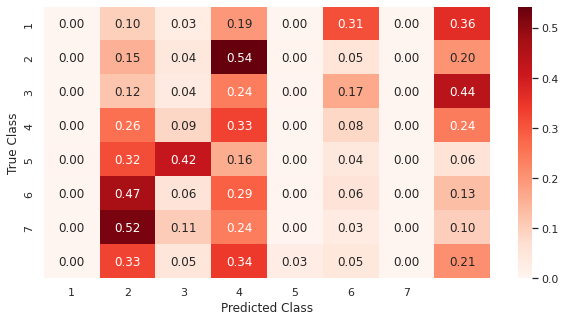

In [61]:
labels_train, labels_test = train_test_split(
    df["sentiment"], test_size=0.2, random_state=42
)
d = {
    "sadness": 1,
    "neutral": 2,
    "worry": 3,
    "surprise": 4,
    "love": 5,
    "fun": 6,
    "happiness": 7,
    "relief": 8,
}

labels_test_code = [d[gen] for gen in labels_test]
conf_matrix(labels_test_code, y_pred, "conf_matrix_direct_embed")